In [28]:
# Manipulación de datos
import numpy as np
import pandas as pd

In [29]:
# Modelamiento de datos
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn import svm, metrics

In [30]:
# Visualización  
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# Dataset

Para comparar las diferentes métricas, vamos a usar el dataset de cáncer de mama, la cual es proveida por scikit-learn
Este dataset es usado para una clasifiación binaria entre dos tipos de cáncer 

In [31]:
data = load_breast_cancer()

In [32]:
print(data.target_names)

['malignant' 'benign']


¿Cúal es la dimensión de los datos? Podemos ver que hay 569 ejemplos y cada uno tiene 30 características.
La variable dependiente is binaria (0 y 1 para malignant(maligno) y benign(benigno)).
Vamos a considerar *bening* como una clase *positiva*, y *maligno* como una clase *negativa*
Nosotros podemos entender esto como:  
0 para no_es_beningno (is_not_benign)  
1 para es_beningno (is_benign)



In [33]:
X = data.data # Características
y = data.target # Etiquetas
print(X.shape, y.shape)

(569, 30) (569,)


# División de datos
Desde que nosotros no podemos entrenar y probar nuestro modelo con el mismo dataset, siempre es una buena idea separar los datos en tres partes - datos de entrenamiento, datos de pruebas, y datos de validación.
No necesitaremos datos de validación aquí. Separamos el dataset en datos de entrenamiento y prueba, con 369 muestras para entrenamiento, y 200 muestras para pruebas.

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=200, random_state=42, stratify=y)

In [35]:
X_test.shape, y_test.shape

((200, 30), (200,))

# Entrenando y pronosticando datos
En este ejemplo, vamos a usar el soporte de scikit's clasificador de máquinas vectoriales para pronosticar si es un cáncer benigno. El clasificador $svc$ es usado de $sklear.svm$. Por su puesto, podemos intentar emplear cualquier otro clasificador y comparar la exactitud.

In [36]:
# kernel='linear', guasiano o polinómica, SVC es usado para clasifiación, SVR para regresión
clasificador = svm.SVC(kernel='linear', probability=True, verbose=True)

Seguiremos con el entrenamiento/pruebas para el modelo con nuestro *dataset de entrenamiento*. El entrenamiento es bastante rápido desde que trabajamos con un dataset relativamente pequeño.

In [37]:
clasificador.fit(X_train,y_train)

[LibSVM]

SVC(kernel='linear', probability=True, verbose=True)

Ahora vamos a guardar los resultados de las predicciones como clases.  
**y_preds** es un **vector 1D** de uno de (0, 1) valores, denotando predicciones como malingno y benigno, respectivamente.

In [38]:
y_preds = clasificador.predict(X_test)

In [39]:
y_preds[:10], y_test[:10]

(array([1, 0, 1, 1, 1, 0, 1, 0, 1, 1]), array([1, 0, 1, 1, 1, 0, 1, 0, 1, 0]))

Métricas de clasificación típicas estan basadas en la matriz de confusión:  
- Accuracy (Exactitud)
- Precision (Precisión)
- Sensitivity/Recall (Sensibilidad/Exhaustividad )
- Specificity (Especifidad)
- F1 Score (Puntaje de F1) 

# Matriz de confusión
También es conocido como matriz de error, es un modelo de tabla específica que permite visualizar el rendimiento de un algoritmo. Las filas son los **valores reales** mientras que las columnas con los **valores pronosticados**. (Esto podría cambiar de acuerdo al contexto de la definición).  
Esto fue implementado por scikit-learn 
[sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html?highlight=confusion_matrix#sklearn.metrics.confusion_matrix)  
 
<img src="https://raw.githubusercontent.com/jorge1qaz/ml/e4587519985badd72214985e23b81fd568edf3dc/confusion%20matrix.png" alt="Matriz de confusión" title="TMatriz de confusión" width=800 height=400 />


In [40]:
matriz_confusion = metrics.confusion_matrix(y_test, y_preds)
matriz_confusion

array([[ 68,   7],
       [  2, 123]], dtype=int64)

In [41]:
mc = metrics.confusion_matrix(y_test[:10], y_preds[:10]) # Pequeño test
mc

array([[3, 1],
       [0, 6]], dtype=int64)

Gráfico de la matriz de confusión

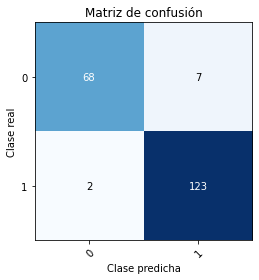

In [42]:
titulo = 'Matriz de confusión'
cmap=plt.cm.Blues
cm = matriz_confusion

# Generar figura
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        title=titulo,
        ylabel='Clase real',
        xlabel='Clase predicha')

# Rotar y alinear ticks
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

# Rellenar gráfica con los valores de la matriz de confusión
fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()

De la matriz de confusión, nosotros podemos ver el número de muestras pronosticadas correctamente por nuestro clasificador, para dos clases distintamente.  
Podemos obtener el número de ***Verdaderos positivos, verdadero negativos, falsos positivos y falsos negativos*** de esta matriz de confusión.
Almacenamos estos términos en algunas variables.

In [43]:
matriz_confusion

array([[ 68,   7],
       [  2, 123]], dtype=int64)

In [44]:
# De la matriz de confusión
VP = ver_pos = matriz_confusion[1][1]
VN = ver_neg = matriz_confusion[0][0]
FP = fal_pos = matriz_confusion[0][1]
FN = fal_neg = matriz_confusion[1][0]

print('VN: ',VN,'; FP: ',FP,'; FN: ',FN,'; VP: ',VP)

VN:  68 ; FP:  7 ; FN:  2 ; VP:  123


Ahora necesitamos calcular algunas métricas básicas de estos cuatro valores.
Necesitamos un diccionario para almacenar estas métricas. Creamos un diccionario llamado *resultados*.

In [45]:
resultados = {}

# 𝐸𝑥𝑎𝑐𝑡𝑖𝑡𝑢𝑑 (Accuracy)
Número de muestras correctamente predichas / total de muestras
$EXACT = (𝑉𝑃+𝑉𝑁)/(𝑉𝑃+𝐹𝑃+𝐹𝑁+𝑉𝑁)$

In [46]:
metrica = "Exactitud"
resultados[metrica] = (VP+VN)/(VP+FP+FN+VN)
print(metrica, resultados[metrica])

Exactitud 0.955


**Tasa de Verdaderos Positivos**  
Número de muestras reales y predichas como **Positivos** / número total de muestras reales **Positivos**  
También llamado ***Sensibilidad o RECALL***.  
$Sensibilidad = 𝑉𝑃/(𝑉𝑃+𝐹𝑁)$ 

In [47]:
metrica = "Sensibilidad"
resultados[metrica] = VP/(VP+FN)
print(metrica, resultados[metrica])

Sensibilidad 0.984


**Tasa de Verdaderos Negativos**
Número de predicciones **negativas correctas**  / número total de **Negativos**   
También llamado ***Especificidad***.  
$Especificidad = VN/(VN+FP)$

In [48]:
# Especificidad
metrica = "Especificidad"
resultados[metrica] = VN/(VN+FP)
print(metrica, resultados[metrica])

Especificidad 0.9066666666666666


# Valor predictivo positivo
Número de muestras reales y predichas como **Positivas** / número total de muestras predichas como **Positivas**  
También llamado ***Precisión***.  
$Precision = VP/(VP+FP)$

In [49]:
# Precisión
metrica = "Precision"
resultados[metrica] = VP/(VP+FP)
print(metrica, resultados[metrica])

Precision 0.9461538461538461


# Puntaje de F1 
Media Armónica de Precisión y Recall  
$F1 = \frac{2}{\frac{1}{Sensibilidad} + \frac{1}{Precisión}} = 2 * \frac{Precisión * Sensibilidad}{Precisión + Sensibilidad}$  



In [50]:
metrica = "F1"
#resultados[metrica] = 2 * ((resultados["Precision"] * resultados["Sensibilidad"])/(resultados["Precision"] + resultados["Sensibilidad"]))
resultados[metrica] = 2 / ((1 / resultados["Sensibilidad"]) + (1 / resultados["Precision"]))
print(metrica, resultados[metrica])

F1 0.9647058823529412


# Comparando las métricas calculadas
Vamos a revisar los valores para comprobar si estos concuerdan con los valores calculados con la ayuda de la librería *scikit-learn*.

In [51]:
from tabulate import tabulate

d = [ ["Exactitud", resultados["Exactitud"],           metrics.accuracy_score(y_test, y_preds)],
     ["Sensibilidad", resultados["Sensibilidad"],      metrics.recall_score(y_test, y_preds)],
     ["Especificidad", resultados["Especificidad"],    metrics.recall_score(y_test, y_preds, pos_label=0)],
     ["Precisión", resultados["Precision"],            metrics.precision_score(y_test, y_preds)],
     ["Puntaje F1", resultados["F1"],                  metrics.f1_score(y_test, y_preds)]]

print(tabulate(d, headers=["Métricas", "Manual", "Scikit-learn"]))

Métricas         Manual    Scikit-learn
-------------  --------  --------------
Exactitud      0.955           0.955
Sensibilidad   0.984           0.984
Especificidad  0.906667        0.906667
Precisión      0.946154        0.946154
Puntaje F1     0.964706        0.964706


In [53]:
# Otras métricas
print("ROC AUC: ", metrics.roc_auc_score(y_test, y_preds))
print("Coeficiente de correlación de Matthews: ", metrics.matthews_corrcoef(y_test, y_preds))

ROC AUC:  0.9453333333333332
Coeficiente de correlación de Matthews:  0.9040243764744805
